# Predict whether or not a patient has diabetes with Logistic regression

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Reading data

In [2]:
df = pd.read_csv('data/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.shape

(768, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## Exploratory Data Analysis

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


* The columns Glucoes, BloodPressure, SkinThickness, Insulin and BMI have min value = 0 which is not possible.
* Pregnancies column has outliers

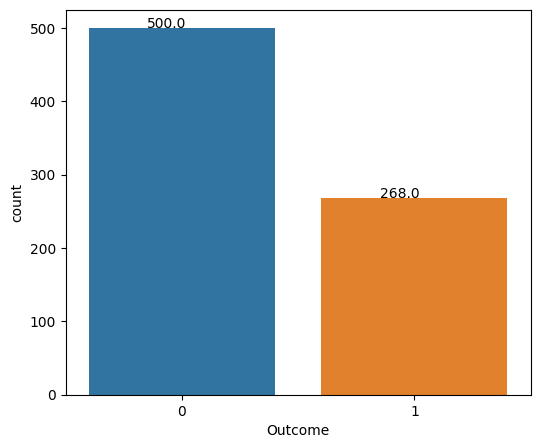

In [6]:
#visualizing target
plt.figure(figsize=(6,5))

ax = sns.countplot(x=df['Outcome'], data=df)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

plt.show()

* Imabalanced dataset
* 500 entries donot have diabets while only 268 datapoints are diabetic

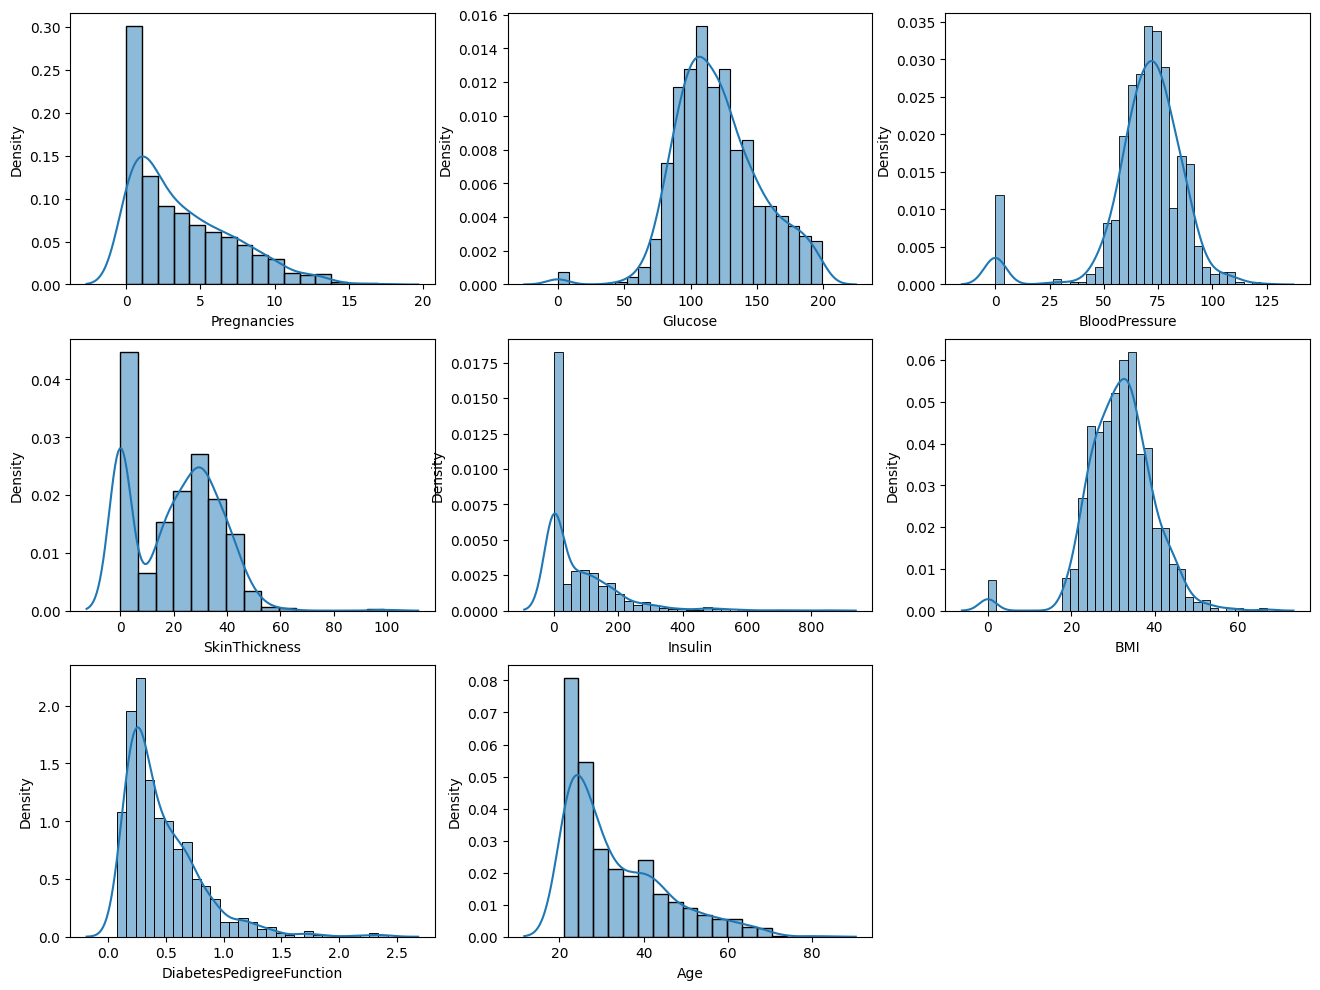

In [7]:
#distributions of features

features = df.columns[:-1]

plt.figure(figsize=(16,12))

for i, col in enumerate(features, 1):
    plt.subplot(3,3,i)
    sns.histplot(data=df, x=col, kde=True, stat='density', kde_kws=dict(cut=3))

* Neglecting the improper min value = 0 Glucose, BMI and BloodPressure follows normal distribution
* All other features follow right skewed distribution

<AxesSubplot: >

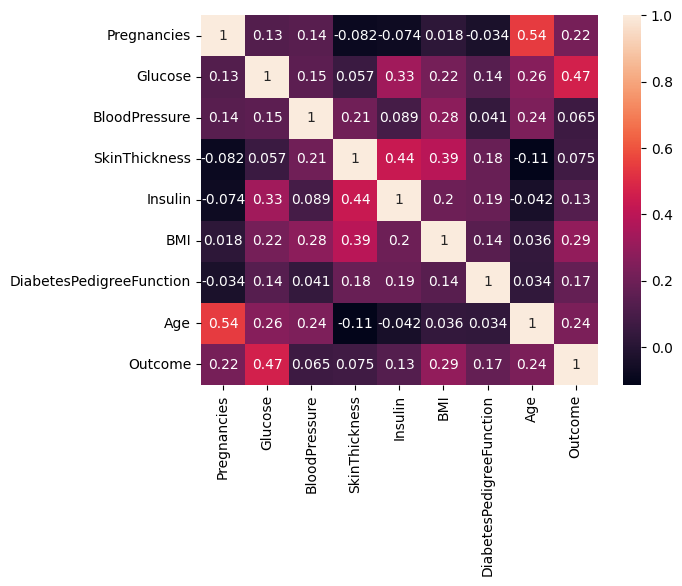

In [9]:
sns.heatmap(df.corr(), annot=True)

* There are no multicollinearity between features

### Data preprocessing

In [10]:
#checking for null values

df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [12]:
#checking for duplicates
df.duplicated().sum()

0

In [13]:
#handling min values = 0 entries
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [16]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [17]:
#Replacin the null values with the mean of that column:

df['Glucose'].fillna(df['Glucose'].mean(), inplace =True)

df['BloodPressure'].fillna(df['BloodPressure'].mean(), inplace =True)

df['SkinThickness'].fillna(df['SkinThickness'].mean(), inplace =True)

df['Insulin'].fillna(df['Insulin'].mean(), inplace =True)

df['BMI'].fillna(df['BMI'].mean(), inplace =True)

In [18]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [29]:
#seprating features and target

X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [30]:
#splitting dataset into train and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Applying SMOTE for handling imbalnced dataset

In [31]:
print("Percentage of Positive Values in training data before Smote :",y_train.value_counts(normalize=True)[1]/(y_train.value_counts(normalize=True)[0]+y_train.value_counts(normalize=True)[1])*100,"%")
print("Percentage of Negative Values in training data before Smote :",y_train.value_counts(normalize=True)[0]/(y_train.value_counts(normalize=True)[0]+y_train.value_counts(normalize=True)[1])*100,"%")

Percentage of Positive Values in training data before Smote : 34.69055374592834 %
Percentage of Negative Values in training data before Smote : 65.30944625407166 %


In [32]:
#appliying SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train,y_train = smote.fit_resample(X_train,y_train)

In [33]:
print("Percentage of Positive Values in training data after Smote :",y_train.value_counts(normalize=True)[1]/(y_train.value_counts(normalize=True)[0]+y_train.value_counts(normalize=True)[1])*100,"%")
print("Percentage of Negative Values in training data after Smote :",y_train.value_counts(normalize=True)[0]/(y_train.value_counts(normalize=True)[0]+y_train.value_counts(normalize=True)[1])*100,"%")

Percentage of Positive Values in training data after Smote : 50.0 %
Percentage of Negative Values in training data after Smote : 50.0 %


In [34]:
#scaling the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model building

In [35]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

### Model evaluation

In [38]:
ypred = lr.predict(X_test)

print ("The accuracy of model is : ", accuracy_score(y_test, ypred))
print()
print("Precision score for model is :", precision_score(y_test, ypred))
print()
print("Recall score for model is :", recall_score(y_test, ypred))
print()
print("f1 score for model is :", f1_score(y_test, ypred))

The accuracy of model is :  0.7727272727272727

Precision score for model is : 0.6470588235294118

Recall score for model is : 0.8

f1 score for model is : 0.7154471544715447
